In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.datasets import make_blobs, make_circles
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set_style("dark")

# Synthetic data

In [2]:
rng = np.random.default_rng(122807520392024100672342163767233424406)

# cluster data
X_uniform = rng.uniform(0, 10, (20, 2))

X_circle, _ = make_circles(n_samples=80, noise=0.2, random_state=42)
addition_matrix = np.zeros((X_circle.shape[0], X_circle.shape[1]))
addition_matrix[:, 0] = 4.5
addition_matrix[:, 1] = -0.5
X_circle = X_circle + addition_matrix

X_blob, _ = make_blobs(n_samples=80, n_features=2, centers=[[3.4, 2.1]], random_state=42)
X_aniso = np.matmul(X_blob, [[0.6, 0.3], [0.3, 1.1]]) # anisotropicly distributed data

X_blobs = np.vstack([X_circle, X_aniso, X_uniform])

# time series data
ts_idx = np.linspace(1, 60, 61)

ts_vals = []
spikes_at = rng.integers(1, 60, 5)
for i in range(ts_idx.size):
    if i == 0:
        ts_val = rng.normal(scale=1)
    else:
        ts_val = rng.normal(loc=0, scale=1) + ts_vals[-1]*0.8
    ts_vals.append(ts_val)


for i in spikes_at:
    ts_vals[i] = ts_vals[i] + rng.normal(scale=6)

ts_vals = np.array(ts_vals)
X_ts = np.array([ts_idx, ts_vals]).T

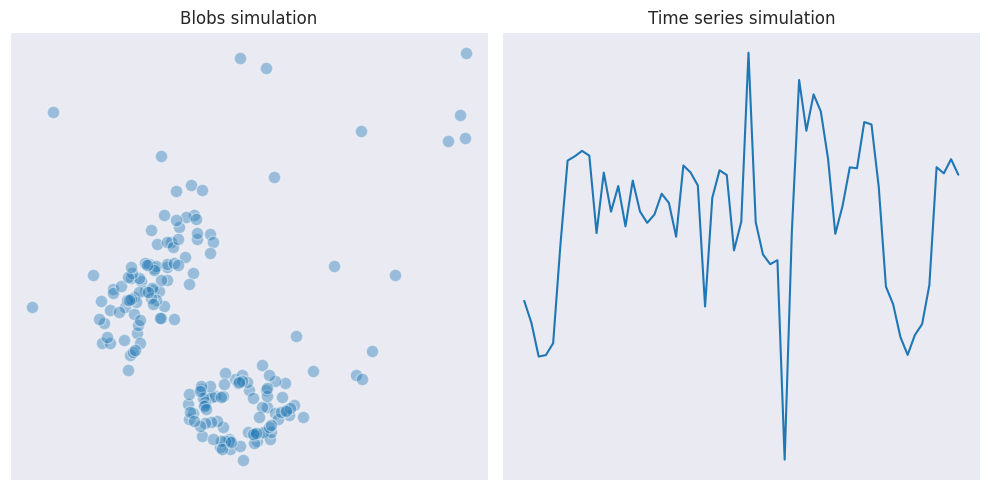

In [21]:
plot_kwds = {'alpha': 0.40, 's': 80, 'linewidths': 1, 'edgecolor': 'white'}

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X_blobs[:, 0], X_blobs[:, 1], **plot_kwds)
ax[1].plot(X_ts[:, 0], X_ts[:, 1])
ax[0].set_title('Blobs simulation')
ax[1].set_title('Time series simulation')
for ax in ax:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('../../assets/images/clustering/data_outliers_detection.png', bbox_inches='tight');

In [30]:
X_ts = StandardScaler().fit_transform(X_ts)

# GLOSH

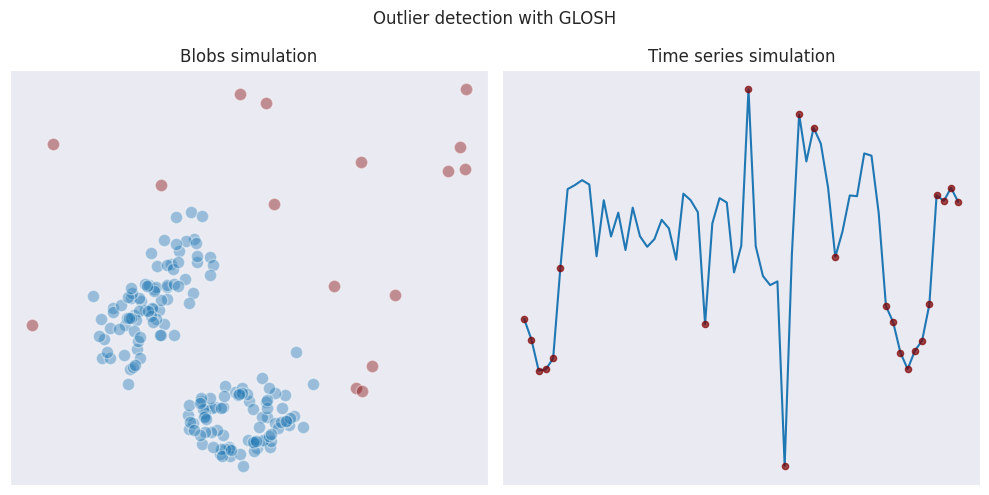

In [51]:
model_hdbscan_blobs = HDBSCAN(min_cluster_size=20, min_samples=5).fit(X_blobs)
model_hdbscan_ts = HDBSCAN(min_samples=7).fit(X_ts)

outliers_blobs = np.where(model_hdbscan_blobs.labels_ == -1)[0]
inliers_blobs = np.where(model_hdbscan_blobs.labels_ != -1)[0]

outliers_ts = np.where(model_hdbscan_ts.labels_ == -1)[0]
inliers_ts = np.where(model_hdbscan_ts.labels_ != -1)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(*X_blobs[inliers_blobs].T, **plot_kwds)
ax[0].scatter(*X_blobs[outliers_blobs].T, **plot_kwds, c='maroon')
ax[0].set_title('Blobs simulation')

ax[1].plot(*X_ts.T)
ax[1].scatter(*X_ts[outliers_ts].T, s=20, c='maroon', zorder=10, alpha=0.7)
ax[1].set_title('Time series simulation')

for ax in ax:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.suptitle('Outlier detection with GLOSH')
plt.tight_layout()
plt.savefig('../../assets/images/clustering/outliers_GLOSH_example.png', bbox_inches='tight');

# LOF

In [36]:
lof_model_blobs = LocalOutlierFactor(n_neighbors=20, contamination='auto').fit(X_blobs)
lof_model_ts = LocalOutlierFactor(n_neighbors=20, contamination='auto').fit(X_ts)

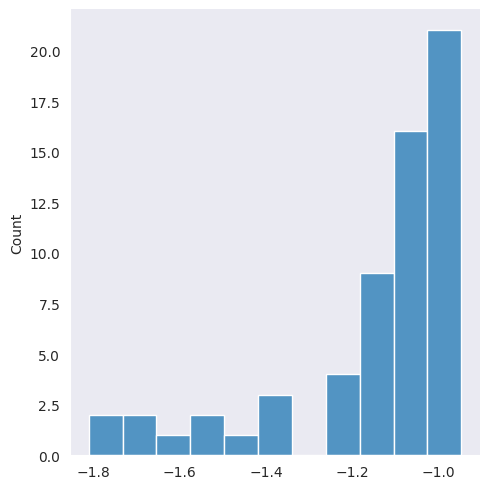

In [38]:
sns.displot(lof_model_ts.negative_outlier_factor_)

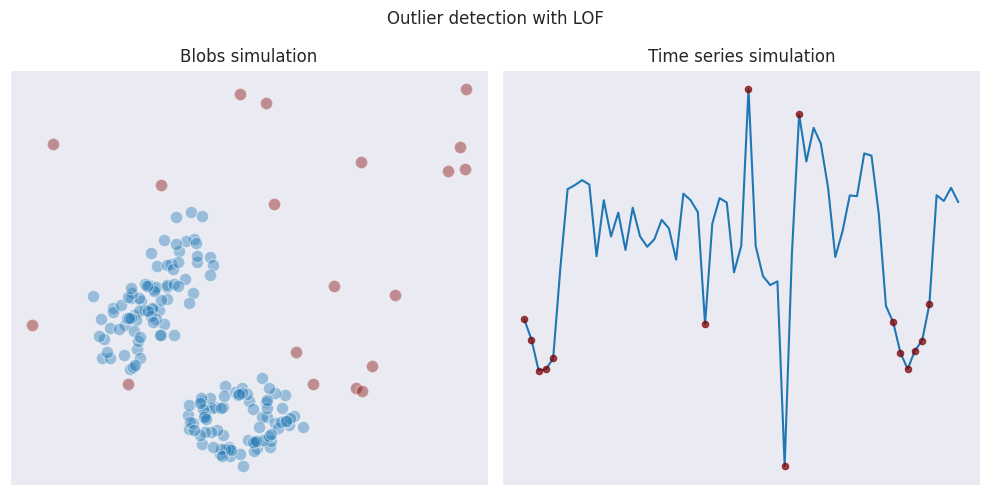

In [44]:
lof_model_blobs = LocalOutlierFactor(n_neighbors=20, contamination='auto').fit(X_blobs)
lof_model_ts = LocalOutlierFactor(n_neighbors=20, contamination='auto').fit(X_ts)

outliers_blobs = np.where(lof_model_blobs.negative_outlier_factor_ < -1.5)[0]
inliers_blobs = np.where(lof_model_blobs.negative_outlier_factor_ >= -1.5)[0]

outliers_ts = np.where(lof_model_ts.negative_outlier_factor_ < -1.2)[0]
inliers_ts = np.where(lof_model_ts.negative_outlier_factor_ >= -1.2)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(*X_blobs[inliers_blobs].T, **plot_kwds)
ax[0].scatter(*X_blobs[outliers_blobs].T, **plot_kwds, c='maroon')
ax[0].set_title('Blobs simulation')

ax[1].plot(*X_ts.T)
ax[1].scatter(*X_ts[outliers_ts].T, s=20, c='maroon', zorder=10, alpha=0.7)
ax[1].set_title('Time series simulation')

for ax in ax:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.suptitle('Outlier detection with LOF')
plt.tight_layout()
plt.savefig('../../assets/images/clustering/outliers_LOF_example.png', bbox_inches='tight');

# Isolation forest

In [71]:
iforest_model_blobs = IsolationForest(random_state=42, contamination='auto').fit(X_blobs)
iforest_model_ts = IsolationForest(random_state=42, contamination='auto').fit(X_ts)

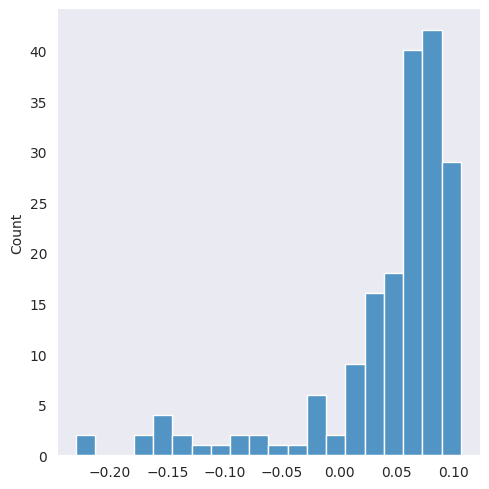

In [72]:
sns.displot(iforest_model_blobs.decision_function(X_blobs))

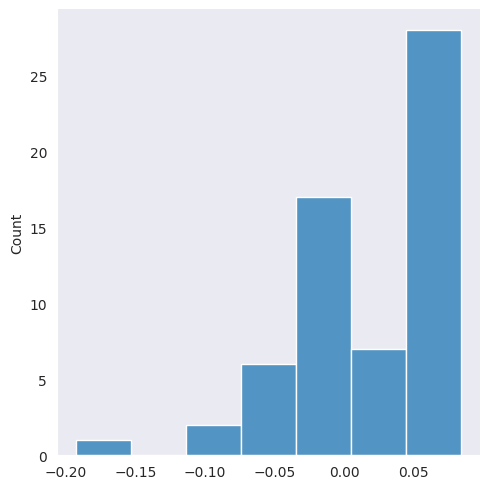

In [73]:
sns.displot(iforest_model_ts.decision_function(X_ts))

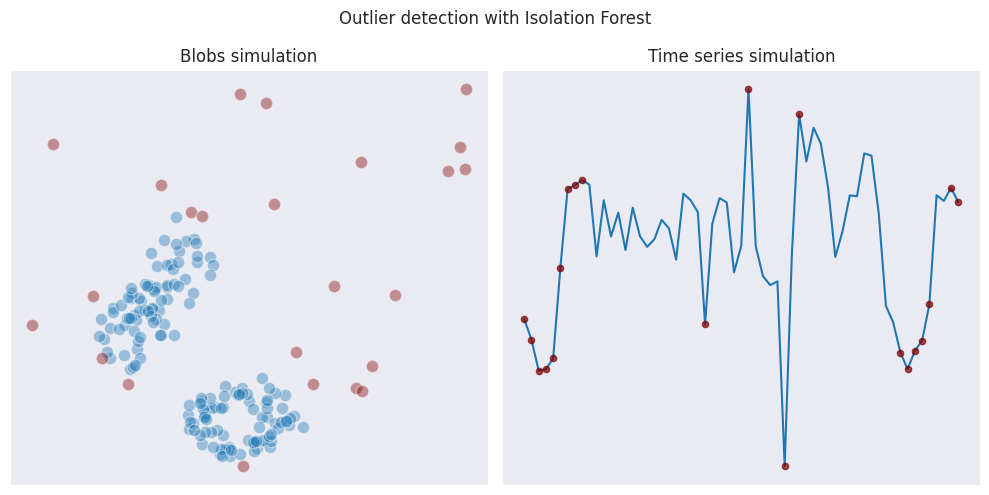

In [78]:
outliers_blobs = np.where(iforest_model_blobs.decision_function(X_blobs) < -0.01)[0]
inliers_blobs = np.where(iforest_model_blobs.decision_function(X_blobs) >= -0.01)[0]

outliers_ts = np.where(iforest_model_ts.decision_function(X_ts) < -0.00)[0]
inliers_ts = np.where(iforest_model_ts.decision_function(X_ts) >= -0.00)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(*X_blobs[inliers_blobs].T, **plot_kwds)
ax[0].scatter(*X_blobs[outliers_blobs].T, **plot_kwds, c='maroon')
ax[0].set_title('Blobs simulation')

ax[1].plot(*X_ts.T)
ax[1].scatter(*X_ts[outliers_ts].T, s=20, c='maroon', zorder=10, alpha=0.7)
ax[1].set_title('Time series simulation')

for ax in ax:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.suptitle('Outlier detection with Isolation Forest')
plt.tight_layout()
plt.savefig('../../assets/images/clustering/outliers_isolation_forest_example.png', bbox_inches='tight');